In [ ]:
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
%%capture

!pip install numpy pandas

!rm -rf ./data/
!mkdir -p ./data/
!wget -c -O ./data/lahman2014.sqlite "https://github.com/jknecht/baseball-archive-sqlite/raw/master/lahman2014.sqlite"

# **Part 1: Wrangling**

## Problem 1:

Yes, there are missing data in the dataset. There are teams that don't have any Salary data at all. There are also some teams that have Salary data for some years but have missing data for some years (perhaps they didn't exist back then?). There are also teams that have Salary data but no Team data.

To deal with missing data (i.e. to only include records that have both Teams and Salary data), I did an `INNER JOIN` from the `Teams` table on the `Salaries` table with `teamId` and `yearId` as keys.

This way, any record with missing salary data would not be included in the query result. The type of JOIN matters here because if I had used a LEFT OR RIGHT JOIN, any missing data (either Teams or Salaries depending on the join) would also be included in the result, which is not what I wanted since I want to associate win percentage with total salary and any data with any one of those values missing is not useful for my analysis.

*(The SQL used for data extraction is included in the code snippet)*

In [ ]:
import sqlite3
import pandas as pd 

db_path = './data/lahman2014.sqlite'
conn = sqlite3.connect(db_path)

sql = """
WITH payroll AS (
	SELECT s.teamID, s.yearID, SUM(s.salary) AS totalSalary
	FROM Salaries s 
	GROUP BY s.teamID, s.yearID
)
SELECT 
	t.teamID, 
	t.yearID AS year, 
	t.lgID,
	t.franchID,
	t.divID,
	t.W as wins,
	t.L as losses,
	t.G as gamesPlayed,
	(t.W * 1.0 / t.G) * 100 AS winPercentage,
	COALESCE(p.totalSalary, 0) AS payroll
FROM Teams t 
INNER JOIN payroll p ON p.teamId = t.teamId AND p.yearID = t.yearID;
"""

base_df = pd.read_sql(sql, conn)
base_df.head()


,teamID,year,lgID,franchID,divID,wins,losses,gamesPlayed,winPercentage,payroll
0,ATL,1985,NL,ATL,W,66,96,162,40.740741,14807000.0
1,BAL,1985,AL,BAL,E,83,78,161,51.552795,11560712.0
2,BOS,1985,AL,BOS,E,81,81,163,49.693252,10897560.0
3,CAL,1985,AL,ANA,W,90,72,162,55.555556,14427894.0
4,CHA,1985,AL,CHW,W,85,77,163,52.147239,9846178.0


# **Part 2: Exploratory Data Analysis**

## Problem 2

**Code** 

For each team, I wanted to plot its total payroll over time. To do that, I first grouped the dataframe by `teamID` and then plotted each group into a subplot. I used a formatter to change the payroll into units of millions to make the graph more readable.

**Inference**

By looking at the graph of each team's payroll over the years, we can see that the total payroll for each team tends to increase as years go by.

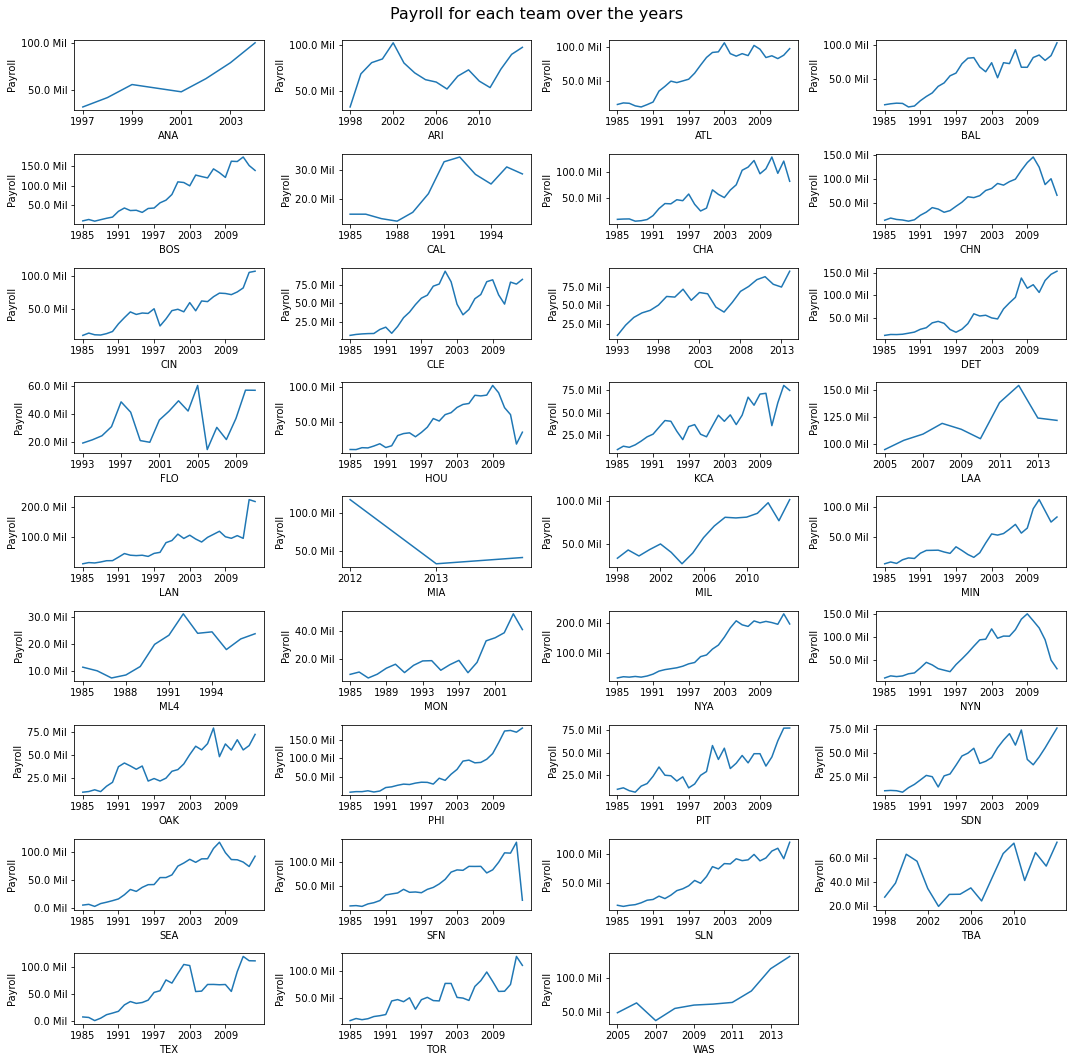

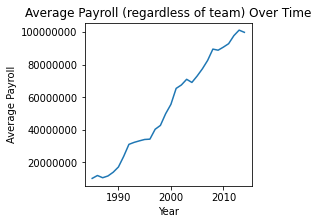

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import numpy as np

def millions(x, pos):
  return '%1.1f Mil' % (x * 1e-6)

formatter = FuncFormatter(millions)

rows = (len(base_df.teamID.unique())/4) + 1
fig, axes = plt.subplots(int(rows), 4, figsize=(15, 15))
fig.tight_layout(h_pad=5, w_pad=5)

team_grp = base_df.groupby("teamID")
for i, (team, df_by_team) in enumerate(team_grp):
  
  r = axes[i // 4]
  ax = r[i % 4]
  ax.yaxis.set_major_formatter(formatter)
  df_by_team.plot.line("year", "payroll", ax=ax, legend=False)
  min_year = df_by_team["year"].min()
  max_year = df_by_team["year"].max()
  step = ((max_year - min_year) // 5) + 1
  ax.xaxis.set_ticks(np.arange(min_year, max_year, step))
  ax.set_xlabel(team)
  ax.set_ylabel("Payroll")

fig.suptitle("Payroll for each team over the years", fontsize=16)
fig.delaxes(axes[8][3])
fig.tight_layout()
plt.subplots_adjust(top=0.95)

# Average payroll by year
average_payroll_over_time = base_df[["year", "payroll"]].groupby(by=["year"], as_index=False).mean()
x = average_payroll_over_time["year"].to_numpy()
y = average_payroll_over_time["payroll"].to_numpy()

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(x, y)
ax.ticklabel_format(style='plain')
plt.title("Average Payroll (regardless of team) Over Time")
plt.xlabel("Year")
plt.ylabel("Average Payroll")
plt.show()

## Problem 3

**Code**

To visualize how the spread of payroll is across different time frames, I created bins of a range of years. For each bin, I then plotted the density in order to visualize the mean and the spread of payroll among the teams in the various years. To plot the density, I used the `kind='density'` option of the `Dataframe.plot` function.

**Inference**

Although the general trend is that the payroll for every team tends to increase every year, the amount by which it increases varies by team (i.e. there is a disparity between the payroll of the richest and the poorest teams). 

This is especially evident when we look at the average payroll distribution over the years. We can see that for the earlier years (1985 ~ 1990) the distributions are narrower, with a narrower spread. However, as the years go by, the distribution of average payroll becomes wider (has higher variance) as the years go by.


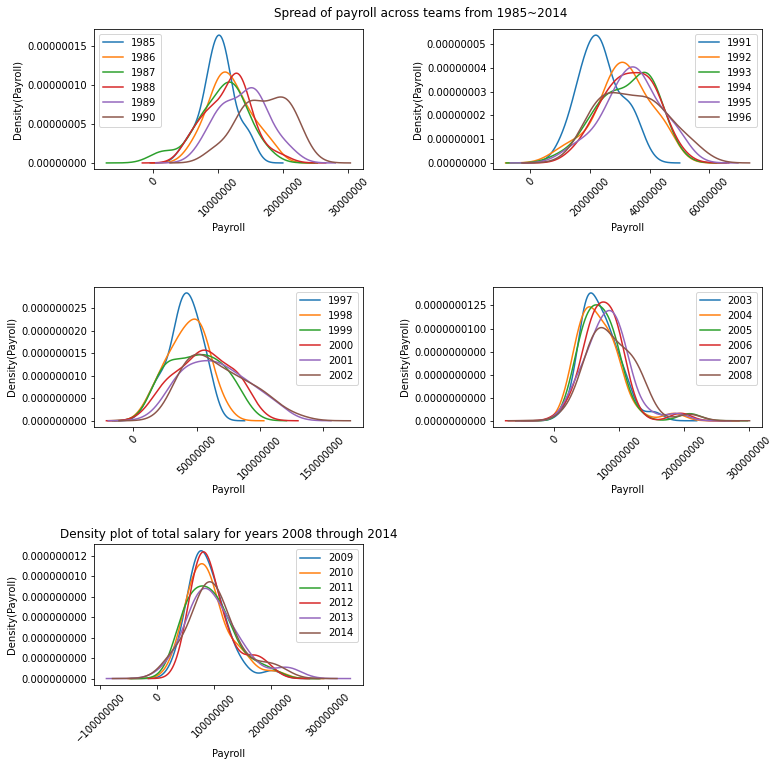

In [ ]:
base_df["year_range"] = pd.cut(base_df['year'], [1984, 1990, 1996, 2002, 2008, 2014])
grouped_df = base_df.groupby("year_range")


fig, axes = plt.subplots(3, 2, figsize=(10, 10))
fig.tight_layout(h_pad=10, w_pad=10)
fig.delaxes(axes[2][1])

for i, (year_range, df_by_range) in enumerate(grouped_df):
  ax = axes[i // 2][i % 2]
  ax.ticklabel_format(style='plain')
  grouped_df = df_by_range.groupby(pd.Grouper("year"))["payroll"].plot(kind="density", legend=True, ax=ax, rot=45)
  plt.title("Density plot of total salary for years {0} through {1}".format(year_range.left, year_range.right))
  ax.set_xlabel("Payroll")
  ax.set_ylabel("Density(Payroll)")
fig.suptitle("Spread of payroll across teams from 1985~2014")
plt.subplots_adjust(top=0.95)

## Problem 4

**Code**
I plotted the mean payroll vs the mean winning percentage for each team in each time range as in the graphs below. To do that, I first grouped the dataframe by `year_range` and `teamID`, and for each `year_range`, I plotted a scatter plot. To make each team distinguishable, I used different color and marker combinations.

**Inference**

The general trend seems to be that the winning percentage tends to increase as the payroll increases. As can be seen from the various graphs, this doesn't apply equally to all teams. Some teams seem to be more efficient in using their money (have higher winning percentage even with a smaller payroll), while some teams fail to increase their winning percentage even by increasing their payroll (these are the teams that are in the lower right side of the graphs).

Based on the data and the graphs, Oakland A's (marked "OAK" in the graphs) seems to be very efficient in spending their money. We can see that OAK is consistently among the teams with lower payrolls and at the same time, is consistently among the teams with a high winrate except from the period 1990 to 1996, where they had a low winning percentage compared to other periods.


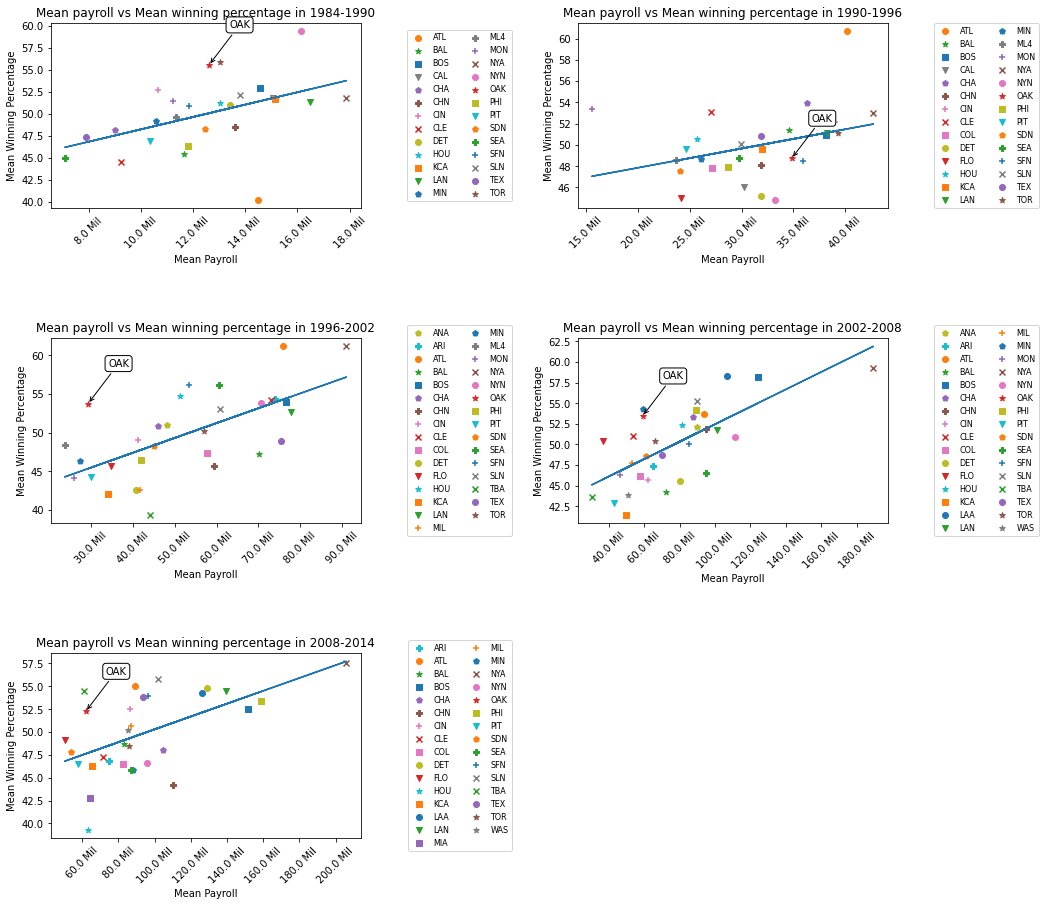

In [ ]:
import matplotlib.cm as cm
import matplotlib


def mark_OAK(x, y, ax):
    n2 = ax.annotate("OAK", xy=(x, y), xycoords="data", 
                xytext=(20, 40), textcoords="offset points",
                va="center", ha="left",
                bbox=dict(boxstyle="round", fc="w"),
                arrowprops=dict(
                    arrowstyle="->", 
                    connectionstyle="arc3",
                    color="black")
    )

def get_marker_and_color(idx):
  markers = ["o", "*", "s", "v", "p", "P", "+", "x"]
  colors = [
      "tab:orange", "tab:green", "tab:blue", "tab:gray", "tab:purple", 
      "tab:brown", "tab:pink", "tab:red", "tab:olive", "tab:cyan"
  ]
  return colors[idx%10], markers[idx % 8]



avg_df = base_df[["year_range", "teamID", "winPercentage", "payroll"]].groupby(by=["year_range", "teamID"], as_index=False).mean()
teams = base_df.teamID.unique()
color_marker_map = {t: get_marker_and_color(i) for i, t in enumerate(teams)}

fig = plt.figure(figsize=(15,15))

for i, (_grp, _df) in enumerate(avg_df.groupby("year_range")):
  plots = []
  labels = []
  ax = fig.add_subplot(3,2, i+1)

  _df = _df.dropna()

  for j, row in _df.iterrows():
    c, m = color_marker_map[row["teamID"]]
    p = plt.scatter(row["payroll"], row["winPercentage"], marker=m, color=c)
    ax.ticklabel_format(style='plain')
    plots.append(p)
    labels.append(row["teamID"])
    if row["teamID"] == "OAK":
      mark_OAK(row["payroll"], row["winPercentage"], ax)

  ax.set_xticklabels(ax.get_xticks(), rotation = 45)
  ax.set_title("Mean payroll vs Mean winning percentage in {0}-{1}".format(_grp.left, _grp.right))
  
  # Plot trendline
  z = np.polyfit(_df["payroll"].to_numpy(), _df["winPercentage"].to_numpy(), 1)
  p = np.poly1d(z)
  plt.plot(_df["payroll"], p(_df["payroll"]))

  _ = plt.legend(plots,
            labels,
            scatterpoints=1,
            loc='center right', bbox_to_anchor=(1.5 , 0.5),
            ncol=2,
            fontsize=8)
  ax.set_ylabel("Mean Winning Percentage")
  ax.set_xlabel("Mean Payroll")
  ax.xaxis.set_major_formatter(formatter)

fig.subplots_adjust(hspace=0.7, wspace=0.7)


# **Part 3: Data Transformations**

## Problem 5

Plotting the standardized payroll gave me a similar graph as the previous one, but instead of the mean payroll values, I have the payroll standardized over the years in my x-axis. This made the graph much more analyzable because the new values are normalized in such a way that the mean falls at x=0 and the values are represented as a measure of how far they are above or below the mean (to the left or right of x=0).

Standardizing in this way helps us look at the data from different time frames in the same way because all of them are represented as a measure of how far they are from their respective means. 
 

In [ ]:
def get_standardized_payroll(row):
  return (row["payroll"] - row["mean"])/row["std"]

df_with_avg = base_df.copy()
averages_by_year = df_with_avg.groupby(["year"], as_index=False).payroll.agg({'mean','std'})
averages_by_year.reset_index(inplace=True)
df_with_avg = df_with_avg.merge(averages_by_year, how="left", on="year")
df_with_avg["standardized_payroll"] = df_with_avg.apply(get_standardized_payroll, axis=1)

df_with_avg.head()

,teamID,year,lgID,franchID,divID,wins,losses,gamesPlayed,winPercentage,payroll,year_range,mean,std,standardized_payroll
0,ATL,1985,NL,ATL,W,66,96,162,40.740741,14807000.0,"(1984, 1990]",1.007557e+07,2.470845e+06,1.914905
1,BAL,1985,AL,BAL,E,83,78,161,51.552795,11560712.0,"(1984, 1990]",1.007557e+07,2.470845e+06,0.601068
2,BOS,1985,AL,BOS,E,81,81,163,49.693252,10897560.0,"(1984, 1990]",1.007557e+07,2.470845e+06,0.332678
3,CAL,1985,AL,ANA,W,90,72,162,55.555556,14427894.0,"(1984, 1990]",1.007557e+07,2.470845e+06,1.761474
4,CHA,1985,AL,CHW,W,85,77,163,52.147239,9846178.0,"(1984, 1990]",1.007557e+07,2.470845e+06,-0.092838


## Problem 6

Plot of average winning percentage of teams against the mean standardized payroll of each team for each of the time ranges.

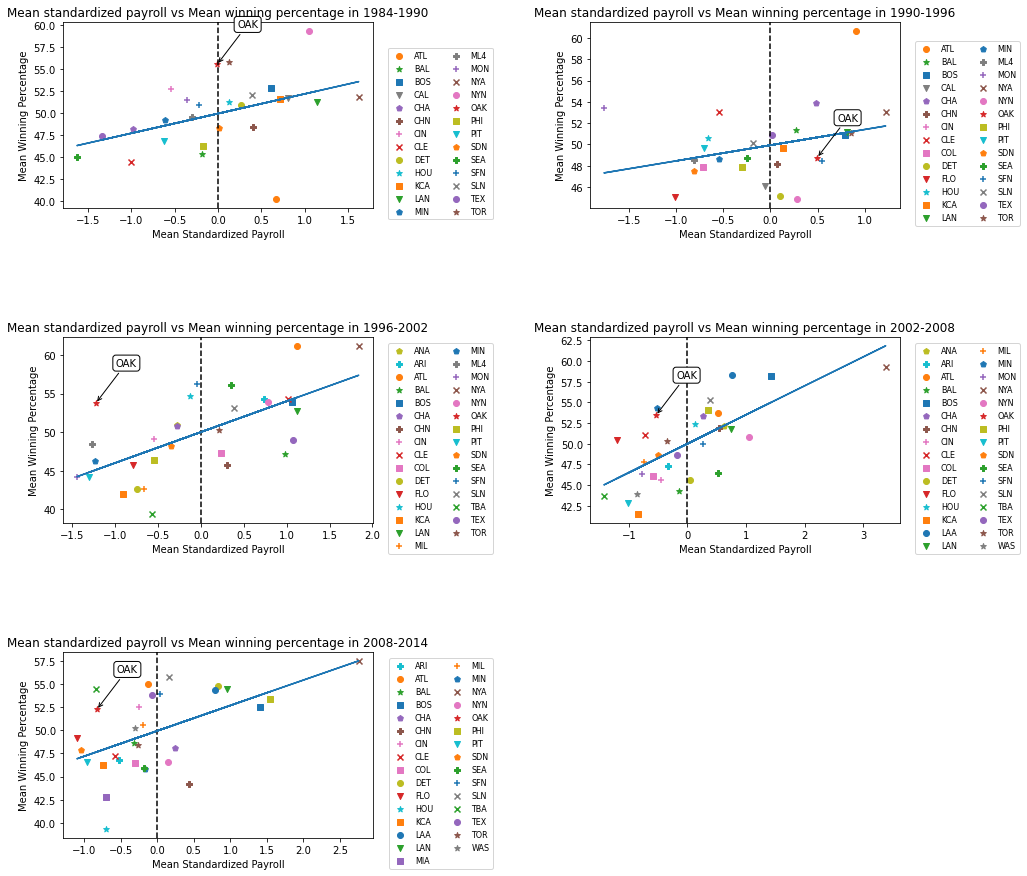

In [ ]:
standardized_df = df_with_avg[["year_range", "teamID", "winPercentage", "standardized_payroll"]].groupby(by=["year_range", "teamID"], as_index=False).mean()

fig = plt.figure(figsize=(15, 15))
for i, (_grp, _df) in enumerate(standardized_df.groupby("year_range")):
  plots = []
  labels = []
  # fig, ax = plt.subplots()
  ax = fig.add_subplot(3, 2, i+1)
  _df = _df.dropna()
  for j, row in _df.iterrows():
    c, m = color_marker_map[row["teamID"]]
    p = plt.scatter(row["standardized_payroll"], row["winPercentage"], marker=m, color=c)
    ax.ticklabel_format(style='plain')
    plots.append(p)
    labels.append(row["teamID"])
    if row["teamID"] == "OAK":
      mark_OAK(row["standardized_payroll"], row["winPercentage"], ax)

  ax.axvline(x=0, color='black', linestyle='dashed')
  ax.set_title("Mean standardized payroll vs Mean winning percentage in {0}-{1}".format(_grp.left, _grp.right))
  
  # Plot trendline
  z = np.polyfit(_df["standardized_payroll"].to_numpy(), _df["winPercentage"].to_numpy(), 1)
  p = np.poly1d(z)
  plt.plot(_df["standardized_payroll"], p(_df["standardized_payroll"]))

  _ = plt.legend(plots,
            labels,
            scatterpoints=1,
            loc='center right', bbox_to_anchor=(1.4 ,0.4),
            ncol=2,
            fontsize=8)
  ax.set_ylabel("Mean Winning Percentage")
  ax.set_xlabel("Mean Standardized Payroll")
fig.subplots_adjust(wspace=0.7, hspace=0.7)

## Problem 7

Scatter plot of winning percentage vs. standardized payroll with regression line.

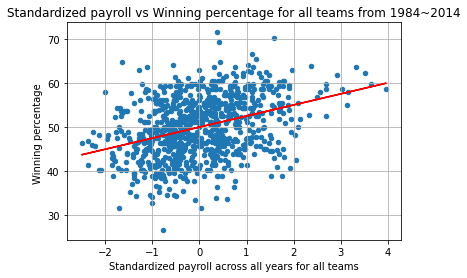

In [ ]:
ax = df_with_avg.plot.scatter("standardized_payroll", "winPercentage")
z = np.polyfit(df_with_avg["standardized_payroll"], df_with_avg["winPercentage"], 1)
p = np.poly1d(z)
plt.title("Standardized payroll vs Winning percentage for all teams from 1984~2014")
plt.plot(df_with_avg["standardized_payroll"], p(df_with_avg["standardized_payroll"]), color="red")
plt.xlabel("Standardized payroll across all years for all teams")
plt.ylabel("Winning percentage ")
plt.grid()

## Problem 8

**Code**

I chose 5 teams `OAK`, `NYA`, `BOS`, `ATL` and `TBA` to compare their respective efficiencies and to keep the graph less messy. I plotted each team in it's own subplot with a shared X-axis to make the comparision easier for each year. To make it easier to see if a particular team is efficient for a particular year, I drew a horizontal line at `y=0` that indicates the point of 0 efficiency. Anything above the line means that the team is efficient, anything below indicates lower efficiency.

**Inference**

From this plot, we can see that any team with efficiency > 0 is efficient in its spending. Compared to the plots in question 2 and 3, this plot makes it easier to see how efficient a team is in spending money. The problem with the plots in question 2 and 3 is that, while we can get a rough idea of how efficient a team is in spending money for a particular time frame, it is harder to compare the efficiencies across different time frames.

The plot for efficiency solves this problem by creating a single measure for indicating efficiency, compared to 2 different indicators in questions 2 & 3 (win percentage and payroll). And since the efficiency itself is standardized, we can plot the efficiency for each team across the whole time frame. As obvious in the graphs below, this makes it very easy to see how efficient a team has been in spending its money over the years.

If we look at OAK's efficiency graph, OAK started out efficiently in the 1980's (getting high percentage of wins with increasing payroll). In the early 1990s, OAK's efficiency went down until around 1996, as it repeatedly had lower win percentages than the average win percentage across teams that year. From 1996, it's win percentage gradually went up around until around 2006, where it's win percentage went below the average win percentage of all teams that year. From 2006 until 2012, OAK's win percentage was close to the average win percentage that year and then it gradually went up until 2014.

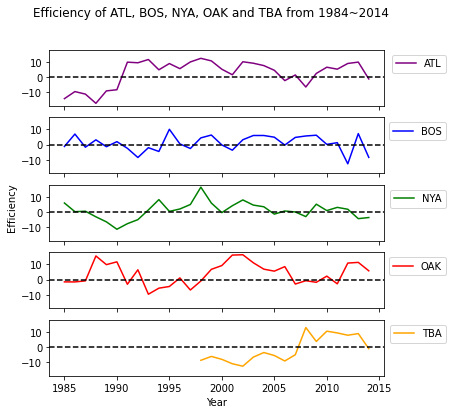

In [ ]:
def calculate_expected_win_percentage(row):
  return 50.0 + (2.5 * row["standardized_payroll"])

df_with_avg["expected_win_percentage"] = 50 + (2.5 * df_with_avg["standardized_payroll"])
df_with_avg["efficiency"] = df_with_avg["winPercentage"] - df_with_avg["expected_win_percentage"]
df_with_avg.head()

fig, axes = plt.subplots(5, 1, sharex=True,sharey=True,figsize=(6,6))
fig.suptitle("Efficiency of ATL, BOS, NYA, OAK and TBA from 1984~2014")
colors = { 
    "OAK": "red", 
    "NYA": "green", 
    "BOS": "blue",
    "ATL": "purple", 
    "TBA":"orange"
}

newdf = df_with_avg[df_with_avg["teamID"].isin(["OAK", "NYA", "BOS", "ATL", "TBA"])]
for i, (key, grp) in enumerate(newdf.groupby(["teamID"])):
  ax = axes[i]
  grp.plot(ax=ax, kind='line', x='year', y='efficiency', c=colors[key], label=key, legend=True)\
    .legend(loc='upper right', bbox_to_anchor=[1.2 ,1])
  ax.axhline(y=0, color='black', linestyle='dashed')
plt.ylabel("Efficiency", position=[0,3])
plt.xlabel("Year")
plt.show()


